# Modeling

First thing, I want to see what the simplest, baseline model for my data is. To do this, I will just find whatever I have that correlates the most with PRICE and then create a model with it.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import functions
import numpy as np
from sklearn.preprocessing import StandardScaler

In [4]:
# Import data
kc = pd.read_csv('../../Data/matthew_clean_data.csv', index_col=0)

In [5]:
# Create Correlation matrix
kc_matrix = kc.corr()
kc_matrix['price']

id             -0.016772
price           1.000000
grade           0.667951
yr_built        0.053953
yr_renovated    0.125499
floors_1.5      0.015896
floors_2.0      0.232696
floors_2.5      0.122845
floors_3.0      0.020036
floors_3.5      0.018132
Name: price, dtype: float64

## Simple Model: Price ~ Grade

In [6]:
# Grade seems to have the highest correlation here. Let's start there

#Train/Test Split
X = kc.drop(columns=['price', 'date', 'yr_renovated'])
y = kc['price']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

model = sm.OLS(y_train, sm.add_constant(X_train['grade'])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                 1.192e+04
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:53:21   Log-Likelihood:            -2.0150e+05
No. Observations:               14469   AIC:                         4.030e+05
Df Residuals:                   14467   BIC:                         4.030e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.28e+05   9172.289    -46.657      0.000   -4.46e+05    -4.1e+05
grade        2.08e+05   1905.320    109.180      0.000    2.04e+05    2.12e+05
==============================================================================
Omnibus:                    12843.408   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1160915.158
Skew:                           3.873   Prob(JB):                         0.00
Kurtosis:                      46.193   Cond. No.                         20.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# For comparing the models, let's also use our evaluate() function to get R2, RMSE, MAE
train_preds = model.predict(sm.add_constant(X_train['grade']))
test_preds = model.predict(sm.add_constant(X_test['grade']))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.4517
Test R2: 0.4350
****
Train RMSE: $270,324.18
Test RMSE: $279,525.27
****
Train MAE: $175,179.47
Test MAE: $175,055.85


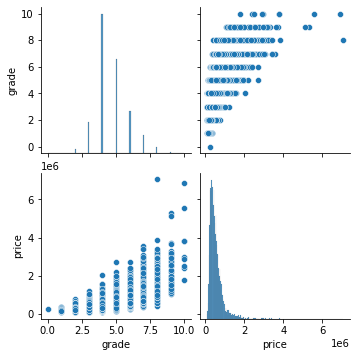

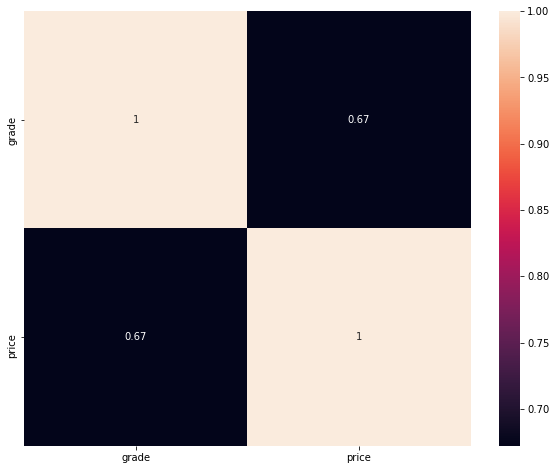

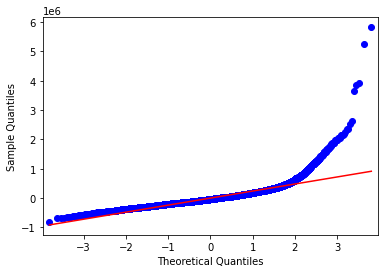

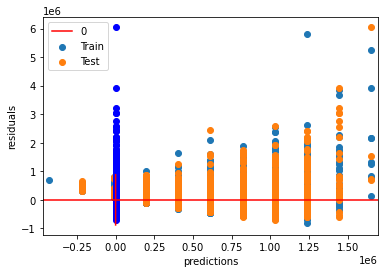

In [8]:
# Let's also check the assumptions of linearity.
functions.check_assumptions(X_train['grade'], y_train, train_preds, test_preds, y_test)

## Conclusion
Looking at the results two things stick out to me:
- The RMSE and MAE have a difference of about $98,000 dollars.

- This model violates the "residual normality" assumption of linear regression. The Jarque-Bera score of 1,991,063 also reinforces this.
- It may also have some heteroscedasticity as well, violating another assumption.

This is definitely a good start, but I think it would benefit any model moving forward to remove the extreme outliers.

## (Price ~ Grade) with removed outliers

In [9]:
# Remove the 5% most expensive houses
kc_trim = kc[kc['price'] < kc['price'].quantile(0.95)]

# Redo the Train/Test Split and exclude outliers
X = kc_trim.drop(columns=['price', 'date', 'yr_renovated'])
y = kc_trim['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

model = sm.OLS(y_train, sm.add_constant(X_train['grade'])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     9529.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:53:26   Log-Likelihood:            -1.8443e+05
No. Observations:               13743   AIC:                         3.689e+05
Df Residuals:                   13741   BIC:                         3.689e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.093e+05   6186.555    -17.664      0.000   -1.21e+05   -9.72e+04
grade       1.296e+05   1327.848     97.619      0.000    1.27e+05    1.32e+05
==============================================================================
Omnibus:                      933.742   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1150.955
Skew:                           0.659   Prob(JB):                    1.18e-250
Kurtosis:                       3.523   Cond. No.                         21.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
train_preds = model.predict(sm.add_constant(X_train['grade']))
test_preds = model.predict(sm.add_constant(X_test['grade']))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.4095
Test R2: 0.3938
****
Train RMSE: $162,874.06
Test RMSE: $163,274.51
****
Train MAE: $128,715.68
Test MAE: $128,497.69


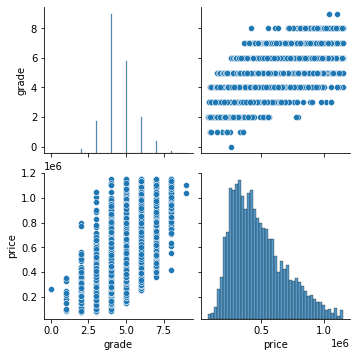

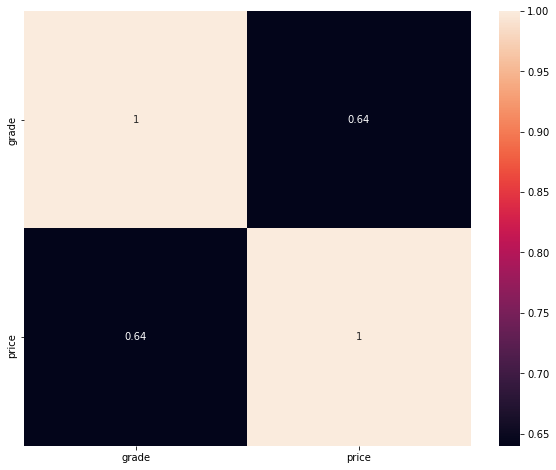

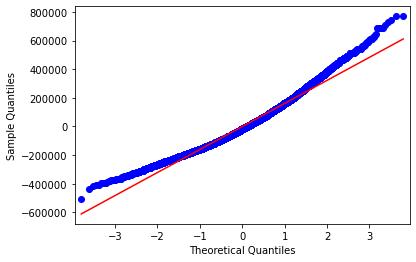

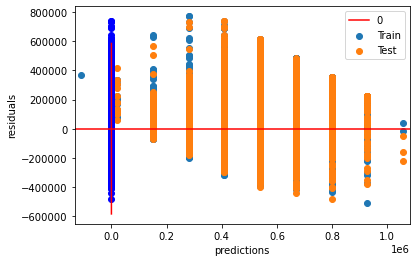

In [11]:
functions.check_assumptions(X_train['grade'], y_train, train_preds, test_preds, y_test)

## Conclusion
This test is interesting:
- The R-Squared went down by about 0.082

but:
- our RMSE went down by about $111,000
- our MSE went down by abour $47,000
- The model still violates the “residual normality” assumption of linear regression. However The Jarque-Bera is now 1270, *much* lower then the previous score of 1,991,063!
- The heteroscedasticity still seems to be present

Overall, I'd say this is an improvement! I think it would be smart to remove outliers like I've done here for any models moving forward. I think it would also be possible to tune the quantile I use to further improve accuracy. For now, I think it'd be better to move on.

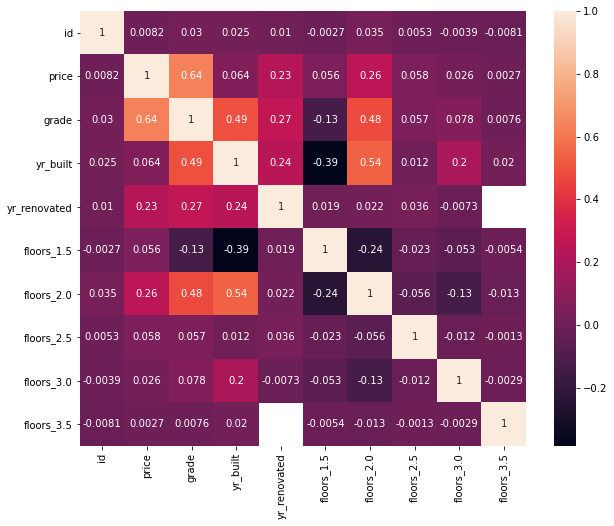

In [12]:
# Before moving forward, I'd like to check the correlation matrix again with removed outliers
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(kc_trim.corr(), annot=True, )
plt.show()

## Renovated
Interestingly, there has been a general uptick in correlations. I think it would be a good idea to investigate the "yr_renovated" column. But let's instead create a column that indicated if a house has been renovated at all, and see if there's any correlation there.

In [13]:
kc_trim['renovated'] = kc_trim['yr_renovated'].notna().astype(int)

<ipython-input-13-f37bbce968aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc_trim['renovated'] = kc_trim['yr_renovated'].notna().astype(int)


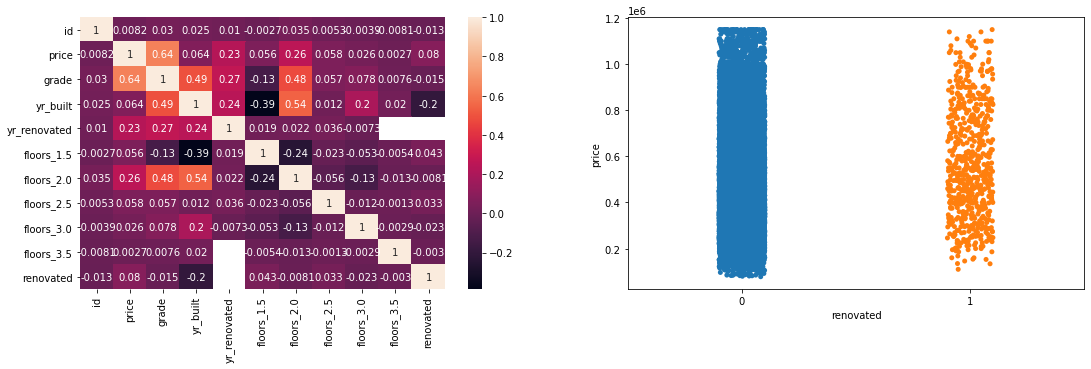

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
sns.heatmap(kc_trim.corr(), annot=True, ax=ax1)
sns.stripplot(data=kc_trim, x='renovated', y='price', ax=ax2)
plt.show()

an interesting feature, but doesn't look anymore useful then 'yr_renovated'

# Price ~ grade + floors_2.0
I'd like to see if adding 'floors_2.0' to our previous model will result in an improvement.

In [15]:
# No need to re-split since this is a new model
model = sm.OLS(y_train, sm.add_constant(X_train[['grade', 'floors_2.0']])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     4813.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:53:35   Log-Likelihood:            -1.8440e+05
No. Observations:               13743   AIC:                         3.688e+05
Df Residuals:                   13740   BIC:                         3.688e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.254e+05   6529.957    -19.200      0.000   -1.38e+05   -1.13e+05
grade       1.352e+05   1514.955     89.230      0.000    1.32e+05    1.38e+05
floors_2.0 -2.489e+04   3289.194     -7.568      0.000   -3.13e+04   -1.84e+04
==============================================================================
Omnibus:                      925.154   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1142.012
Skew:                           0.652   Prob(JB):                    1.04e-248
Kurtosis:                       3.541   Cond. No.                         23.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
train_preds = model.predict(sm.add_constant(X_train[['grade', 'floors_2.0']]))
test_preds = model.predict(sm.add_constant(X_test[['grade', 'floors_2.0']]))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.4120
Test R2: 0.3978
****
Train RMSE: $162,535.68
Test RMSE: $162,735.59
****
Train MAE: $128,353.30
Test MAE: $127,931.72


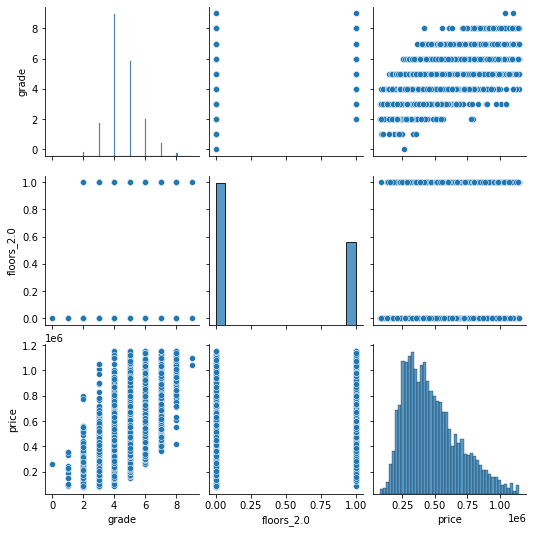

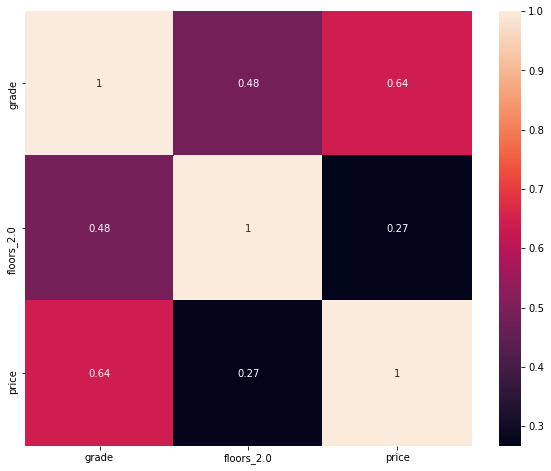

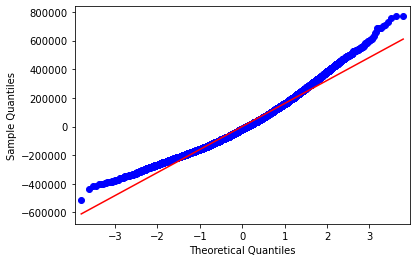

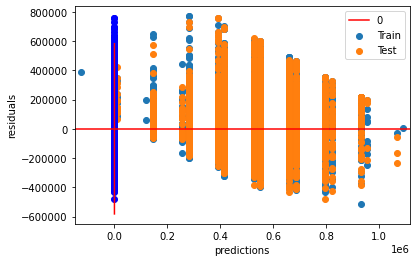

In [17]:
functions.check_assumptions(X_train[['grade', 'floors_2.0']], y_train, train_preds, test_preds, y_test)

## Conclusion
Overall, a **very small** increase in performance across all categories, but it still containes the same issues as the previous model (assumptions of linearity). This is an improvement for sure, however, I think it would be more effective to move on to combining what I have here with some of my partners' models. I think that any more experimintation here would only result in minor increase to performance, as seen in this last model.

## Cleaned Columns ~ Price
I want to get a quick overview of all of our clean columns so that I can better help my group put the final model together

In [18]:
# Import Steve and Tony's cleaned data
s = pd.read_csv('../../Data/my_filtered_dataframe_id.csv', index_col=0)
t = pd.read_csv('../../Data/cleanhousedata_id.csv', index_col=0)

In [19]:
# Setting index to ID column for merging
t.set_index('id')
kc.set_index('id')
s.set_index('id')

,price,date,yr_renovated,yr_built,condition,grade,view,waterfront,zipcode,lat,long,cat_waterfront,cat_view,cat_condition,cat_grade,cat_zipcode
id,,,,,,,,,,,,,,,,
7129300520,221900.0,10/13/2014,NaN,1955,3,4,NONE,NaN,98178,47.5112,-122.257,NaN,NONE,Average,7 Average,98178
6414100192,538000.0,12/9/2014,1991.0,1951,3,4,NONE,NO,98125,47.7210,-122.319,NO,NONE,Average,7 Average,98125
5631500400,180000.0,2/25/2015,NaN,1933,3,3,NONE,NO,98028,47.7379,-122.233,NO,NONE,Average,6 Low Average,98028
2487200875,604000.0,12/9/2014,NaN,1965,5,4,NONE,NO,98136,47.5208,-122.393,NO,NONE,Very Good,7 Average,98136
1954400510,510000.0,2/18/2015,NaN,1987,3,5,NONE,NO,98074,47.6168,-122.045,NO,NONE,Average,8 Good,98074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,360000.0,5/21/2014,NaN,2009,3,5,NONE,NO,98103,47.6993,-122.346,NO,NONE,Average,8 Good,98103
6600060120,400000.0,2/23/2015,NaN,2014,3,5,NONE,NO,98146,47.5107,-122.362,NO,NONE,Average,8 Good,98146
1523300141,402101.0,6/23/2014,NaN,2009,3,4,NONE,NO,98144,47.5944,-122.299,NO,NONE,Average,7 Average,98144


In [20]:
# Merging all cleaned data
kct = kc_trim.merge(t, on='id')
all_clean = kct.merge(s, on='id')
all_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18183 entries, 0 to 18182
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              18183 non-null  int64  
 1   price_x         18183 non-null  float64
 2   grade_x         18183 non-null  int64  
 3   date_x          18183 non-null  object 
 4   yr_built_x      18183 non-null  int64  
 5   yr_renovated_x  452 non-null    float64
 6   floors_1.5      18183 non-null  int64  
 7   floors_2.0      18183 non-null  int64  
 8   floors_2.5      18183 non-null  int64  
 9   floors_3.0      18183 non-null  int64  
 10  floors_3.5      18183 non-null  int64  
 11  renovated       18183 non-null  int64  
 12  price_y         18183 non-null  float64
 13  view_x          18183 non-null  object 
 14  sqft_living     18183 non-null  int64  
 15  sqft_lot        18183 non-null  int64  
 16  bedrooms        18183 non-null  int64  
 17  bathrooms       18183 non-null 

In [21]:
# For this model, I want to just put in as many variables as I can and see what happens. First I remove any category columns or columns with NAN in them.
all_clean.drop(axis=1, labels=['view_y', 'price_y', 'grade_y', 'yr_built_y', 'date_y', 'yr_renovated_y'], inplace=True)

In [22]:
all_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18183 entries, 0 to 18182
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              18183 non-null  int64  
 1   price_x         18183 non-null  float64
 2   grade_x         18183 non-null  int64  
 3   date_x          18183 non-null  object 
 4   yr_built_x      18183 non-null  int64  
 5   yr_renovated_x  452 non-null    float64
 6   floors_1.5      18183 non-null  int64  
 7   floors_2.0      18183 non-null  int64  
 8   floors_2.5      18183 non-null  int64  
 9   floors_3.0      18183 non-null  int64  
 10  floors_3.5      18183 non-null  int64  
 11  renovated       18183 non-null  int64  
 12  view_x          18183 non-null  object 
 13  sqft_living     18183 non-null  int64  
 14  sqft_lot        18183 non-null  int64  
 15  bedrooms        18183 non-null  int64  
 16  bathrooms       18183 non-null  int64  
 17  price           18183 non-null 

In [23]:
ss  = StandardScaler()

# Dropping copies of columns and price
X = all_clean.drop(columns=['price', 'date_x', 'yr_renovated_x', 'waterfront', 'cat_waterfront', 'view_x', 'cat_view', 'cat_condition', 'cat_grade', 'price_x'])

# Column names for future use
colms = X.columns
y = all_clean['price']
# Scale all features
X = ss.fit_transform(X)
# Placing back into a dataframe
X = pd.DataFrame(X, columns=colms)

# TTS
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)



In [24]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
# Getting a summary and formatting it to not be in Scientific notation
model.summary2(float_format='%.4f')

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
=========================================================================
Model:                 OLS               Adj. R-squared:      0.601      
Dependent Variable:    price             AIC:                 312345.6677
Date:                  2021-10-08 10:53  BIC:                 312479.0066
No. Observations:      12182             Log-Likelihood:      -1.5615e+05
Df Model:              17                F-statistic:         1080.      
Df Residuals:          12164             Prob (F-statistic):  0.00       
R-squared:             0.601             Scale:               7.9830e+09 
-------------------------------------------------------------------------
               Coef.     Std.Err.    t     P>|t|     [0.025      0.975]  
-------------------------------------------------------------------------
const       404478.0314  809.6170 499.5918 0.0000 402891.0533 406065.0094
id            2501.8592  823.6119   3.0377 0.0024    887.4490   4116.2694
grade_x      52354.6118 1180.7337  44.3407 0.0000  50040.1860  54669.0375
yr_built_x  -33376.0353 1402.4470 -23.7984 0.0000 -36125.0544 -30627.0162
floors_1.5    5848.2074  884.2164   6.6140 0.0000   4115.0027   7581.4122
floors_2.0   10377.8207 1119.6112   9.2691 0.0000   8183.2046  12572.4368
floors_2.5    4150.0578  810.2370   5.1220 0.0000   2561.8645   5738.2511
floors_3.0    6182.7446  923.1074   6.6978 0.0000   4373.3073   7992.1820
floors_3.5    1329.9460  813.4281   1.6350 0.1021   -264.5024   2924.3945
renovated      902.1399  836.1119   1.0790 0.2806   -736.7723   2541.0521
sqft_living  40948.7552 1420.7517  28.8219 0.0000  38163.8559  43733.6545
sqft_lot     10270.6121  910.9416  11.2747 0.0000   8485.0217  12056.2025
bedrooms     -9803.2914 1074.3320  -9.1250 0.0000 -11909.1530  -7697.4299
bathrooms    16503.3196 1366.9214  12.0733 0.0000  13823.9362  19182.7030
condition    11953.5567  876.1500  13.6433 0.0000  10236.1634  13670.9501
zipcode      -2758.3275  514.1157  -5.3652 0.0000  -3766.0759  -1750.5790
lat          67665.6362  875.2187  77.3128 0.0000  65950.0684  69381.2040
long          3963.2924 1053.4452   3.7622 0.0002   1898.3722   6028.2126
cat_zipcode  -2758.3275  514.1157  -5.3652 0.0000  -3766.0759  -1750.5790
-------------------------------------------------------------------------
Omnibus:            234.962      Durbin-Watson:         1.973            
Prob(Omnibus):      0.000        Jarque-Bera (JB):      281.839          
Skew:               0.281        Prob(JB):              0.000            
Kurtosis:           3.489        Condition No.:         20649759234031600
=========================================================================
* The condition number is large (2e+16). This might indicate
strong multicollinearity or other numerical problems.
"""

In [25]:
# Get the Coefficients and sort them for direct comparison
model.params.sort_values(ascending=False)


const          404478.031364
lat             67665.636224
grade_x         52354.611762
sqft_living     40948.755225
bathrooms       16503.319596
condition       11953.556727
floors_2.0      10377.820716
sqft_lot        10270.612124
floors_3.0       6182.744625
floors_1.5       5848.207437
floors_2.5       4150.057821
long             3963.292378
id               2501.859204
floors_3.5       1329.946029
renovated         902.139909
zipcode         -2758.327476
cat_zipcode     -2758.327476
bedrooms        -9803.291446
yr_built_x     -33376.035293
dtype: float64

In [26]:
# Evaluating this "draft" of our final model
train_preds = model.predict(sm.add_constant(X_train))
test_preds = model.predict(sm.add_constant(X_test))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.6014
Test R2: 0.6052
****
Train RMSE: $89,281.59
Test RMSE: $89,092.13
****
Train MAE: $70,003.53
Test MAE: $69,449.95


In [ ]:
# Also checking assumptions of "draft" final model
functions.check_assumptions(X_train, y_train, train_preds, test_preds, y_test)

## Conclusion
I just wanted to throw all of our cleaned data together to see what happened. This model is decent, but extremely flawed
- There are some huge multicolinearity issues that will need to be addressed.
- Residual normality is okay, but still not in a good spot
- I'm almost certain that this scatter plot for checking heteroskedacity should not look like this.